In [26]:
### import librairies ###
print(f"Importing librairies ... ", end='')
import sys
sys.path.append(r"C:\Users\valentin\Documents\HMM")
import numpy as np
from myHmmPackage.cluster_decoder import ClusterDecoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
print('done')

Importing librairies ... done


In [9]:
### data ###
n_samples = 100 #n_trials
n_time_points = 102
n_regions = 2 #IC ou region ou electrod ou channels
n_label_features = 48 
n_clusters = 4 # n_clusters

In [78]:
y = (np.random.randint(100, size=(n_samples, n_time_points, n_label_features)) == 0).astype(int)
# eps
X = np.random.randint(100,size=(n_samples, n_time_points, n_regions))

W = np.random.randint(low=-10, high=10,size=(n_clusters, n_regions, n_label_features))
W_temp = np.reshape(W, newshape=(n_regions, n_clusters, n_label_features))

gamma_transition = np.random.randint(n_time_points,size=(n_clusters))
gamma_transition = np.concatenate(([0],np.sort(gamma_transition),[n_time_points]))

gamma = np.random.randint(2, size=(n_time_points,n_clusters))
gamma = np.array([[1 if (gamma_transition[(j)] <= i) and (i < gamma_transition[(j+1)]) else 0 for i in range(n_time_points)  ] 
                for j in range(n_clusters)],dtype=int)
gamma = np.transpose(gamma,(1,0))

y = X @ np.sum(gamma @ W_temp, axis=1)
y = np.reshape(y, newshape=(n_samples, n_time_points, n_label_features))

[  0  74  83  88 101 102]


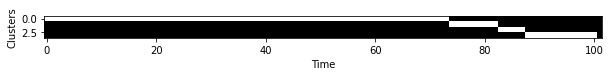

In [79]:
plt.figure(figsize=(10,5))
plt.imshow(gamma.T,cmap='gray')
plt.xlabel("Time")
plt.ylabel("Clusters")
plt.show()

In [87]:
print(f"Starting cluster decoder ... ")
clf = ClusterDecoder(n_clusters=n_clusters, method='sequential', max_iter=1e4)
clf.fit(X,y) # renvoie gamma et W
print('done\n')


Starting cluster decoder ... 


 40%|████      | 4008/9999 [00:41<01:36, 62.20it/s] 

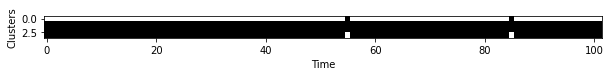

In [85]:
plt.figure(figsize=(10,5))
plt.imshow(clf.gamma_.T,cmap='gray')
plt.xlabel("Time")
plt.ylabel("Clusters")
plt.show()

In [34]:

gamma_true = gamma.flatten()
gamma_predict = clf.gamma_.flatten()
print(f"r2_score : {r2_score(gamma_true, gamma_predict)}")
print(f"mean_squared_error : {mean_squared_error(gamma_true, gamma_predict)}")    
print(f"mean_absolute_percentage_error : {mean_absolute_percentage_error(gamma_true, gamma_predict)}")

r2_score : -0.933649289099526
mean_squared_error : 0.48284313725490197
mean_absolute_percentage_error : 485682312755642.1
